In [1]:
import joblib
import pandas as pd
import argparse
import os
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score, recall_score,
    precision_score, f1_score, matthews_corrcoef
)
from flaml import AutoML
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold

/n/groups/patel/adithya/scenv/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
metadata = pd.read_parquet('/home/adm808/New_CellMetadataSyn1848517.parquet')
print("Metadata is loaded")

# Process APOE genotype as categorical -- Hot encoding of apoe_genotype
metadata = pd.get_dummies(metadata, columns=["apoe_genotype"])
apoe_genotype_columns = [col for col in metadata.columns if col.startswith("apoe_genotype_")]


# Stratified Shuffle Split based on `sample_id`to split metadata
# Define Alzheimer's or control status directly based on `age_first_ad_dx`
metadata = metadata.copy()
metadata['alzheimers_or_control'] = metadata['age_first_ad_dx'].notnull().astype(int)

# Extract unique sample IDs and their associated Alzheimer's/control status -- drop duplicates
sample_summary = metadata[['sample', 'alzheimers_or_control', 'msex']].drop_duplicates()

# I need to create a combined stratification variable
sample_summary['stratify_group'] = sample_summary['alzheimers_or_control'].astype(str) + "_" + sample_summary['msex'].astype(str)

# Perform stratified train-test split on `sample_id`, stratified by `alzheimers_or_control`
train_samples, test_samples = train_test_split(
    sample_summary['sample'],
    test_size=0.2,
    random_state=4,
    stratify=sample_summary['stratify_group']
)

# Filter metadata by train and test `sample_id`
train_metadata = metadata[metadata['sample'].isin(train_samples)]
test_metadata = metadata[metadata['sample'].isin(test_samples)]

# Filter both the training and testing for cell type -- This is cell on cell prediction
# train_metadata = train_metadata[train_metadata['broad.cell.type'] == cell_type]
# test_metadata = test_metadata[test_metadata['broad.cell.type'] == cell_type]


print(f"Number of cases in training: {sum(train_metadata['alzheimers_or_control'])}")
print(f"Number of cases in test: {sum(test_metadata['alzheimers_or_control'])}")

# Function to select and drop missing genes
def select_missing_genes(filtered_matrix):
    mean_threshold = 2
    missingness_threshold = 90

    mean_gene_expression = filtered_matrix.mean(axis=0)
    missingness = (filtered_matrix == 0).sum(axis=0) / filtered_matrix.shape[0] * 100
    null_expression = (missingness > missingness_threshold) & (mean_gene_expression < mean_threshold)
    genes_to_drop = filtered_matrix.columns[null_expression].tolist()

    return genes_to_drop

# Load and transpose gene expression matrices
gene_matrix = pd.read_parquet('/home/adm808/NormalizedCellMatrixSyn18485175.parquet').T
print("Gene matrix is loaded")
print(gene_matrix.iloc[:, :5].head())

# Defining training and testing matrices
train_matrix = gene_matrix.loc[train_metadata['TAG']]
test_matrix = gene_matrix.loc[test_metadata['TAG']]

print("Printing dimensionality of X_train and X_test initallly")
print(train_matrix.shape)
print(test_matrix.shape)

# Filter missing genes
train_matrix_filtered = train_matrix.drop(select_missing_genes(train_matrix), axis=1)
test_matrix_filtered = test_matrix.drop(select_missing_genes(test_matrix), axis=1)

# Merge the train and test matrices with their respective metadata files

train_data = train_matrix_filtered.merge(
    train_metadata[['TAG', 'msex', 'sample', 'broad.cell.type', 'alzheimers_or_control', 'age_death', 'educ', 'cts_mmse30_lv', 'pmi'] + apoe_genotype_columns],
    left_index=True,
    right_on='TAG',
    how='inner'
).set_index('TAG')

test_data = test_matrix_filtered.merge(
    test_metadata[['TAG', 'msex', 'sample', 'broad.cell.type', 'alzheimers_or_control', 'age_death', 'educ', 'cts_mmse30_lv', 'pmi'] + apoe_genotype_columns],
    left_index=True,
    right_on='TAG',
    how='inner'
).set_index('TAG')


# Clean column names for model compatibility
train_data.columns = train_data.columns.str.replace(r'[^A-Za-z0-9_]+', '', regex=True)
test_data.columns = test_data.columns.str.replace(r'[^A-Za-z0-9_]+', '', regex=True)

# Ensure common genes are used between training and testing sets
common_genes = train_data.columns.intersection(test_data.columns)
X_train = train_data[common_genes]
X_test = test_data[common_genes]



Metadata is loaded
Number of cases in training: 21723
Number of cases in test: 4425
Gene matrix is loaded
                    FO538757.2  SAMD11     NOC2L  KLHL17  PLEKHN1
AAACGGGAGATCCCGC.1    0.000000     0.0  0.000000     0.0      0.0
AAATGCCTCCAATGGT.1    6.919779     0.0  0.000000     0.0      0.0
AACCATGTCAGTGCAT.1   11.637401     0.0  0.000000     0.0      0.0
AACCATGTCTGTACGA.1    0.000000     0.0  6.974242     0.0      0.0
AACCGCGTCCGCATAA.1    7.831354     0.0  0.000000     0.0      0.0
Printing dimensionality of X_train and X_test initallly
(55892, 17926)
(14742, 17926)


In [13]:
common_genes = train_data.columns.intersection(test_data.columns)
X_train = train_data[common_genes]
X_test = test_data[common_genes]

In [14]:
# Drop the alzheimers or control column from the dataset
X_train = X_train.drop(columns=['alzheimers_or_control'])
X_test = X_test.drop(columns=['alzheimers_or_control'])

# Map original column names to cleaned names for later interpretability
original_columns = common_genes  # Use common genes after filtering
cleaned_columns = original_columns.str.replace(r'[^A-Za-z0-9_]+', '', regex=True)
column_mapping = dict(zip(cleaned_columns, original_columns))

# Define the target variable
y_train = train_data['alzheimers_or_control']
y_test = test_data['alzheimers_or_control']

print("Printing dimensionality of X_train and X_test post filtering and merging")

print(X_train.shape)
print(X_test.shape)

X_train.loc[X_train.age_death == '90+', 'age_death'] = 90
X_test.loc[X_test.age_death == '90+', 'age_death'] = 90
X_train.age_death = X_train.age_death.astype(float)
X_test.age_death = X_test.age_death.astype(float)


# cell_log_dir = os.path.join(log_dir_path, cell_type)
#cell_log_dir = os.path.join(log_dir_path, 'all_cell_types')

# Create the directory if it doesn’t exist
#os.makedirs(cell_log_dir, exist_ok=True)

# Dropping samples from the dataset
X_train = X_train.drop(columns=['sample', 'cts_mmse30_lv'#, 'pmi'
                                ])
X_test = X_test.drop(columns=['sample', 'cts_mmse30_lv'#, 'pmi'
                              ])

class_weight_ratio = (len(y_train) / (2 * np.bincount(y_train)))  # inverse frequency
sample_weight = np.array([class_weight_ratio[label] for label in y_train])

Printing dimensionality of X_train and X_test post filtering and merging
(55892, 5871)
(14742, 5871)


In [15]:
clf = joblib.load('/n/groups/patel/adithya/Alz_Outputs/Both_with_PMI/F1_Class_weight_less_features_Total/all_cell_types/maximal_classifier.joblib')

clf

AutoML(append_log=False, auto_augment=True, custom_hp={},
       cv_score_agg_func=None, early_stop=False, ensemble=False,
       estimator_list='auto', eval_method='auto', fit_kwargs_by_estimator={},
       force_cancel=False, free_mem_ratio=0, hpo_method='auto',
       keep_search_state=False, learner_selector='sample', log_file_name='',
       log_training_metric=False, log_type='better', max_iter=None,
       mem_thres=4294967296, metric='auto', metric_constraints=[],
       min_sample_size=10000, mlflow_logging=True, model_history=False,
       n_concurrent_trials=1, n_jobs=-1, n_splits=5, pred_time_limit=inf,
       preserve_checkpoint=True, retrain_full=True, ...)

In [25]:
log_file = pd.read_csv('/n/groups/patel/adithya/Alz_Outputs/Both_with_PMI/F1_Class_weight_less_features_Total/all_cell_types/all_features_log.txt')

In [27]:
log_file.head()

,"{""record_id"": 0","""iter_per_learner"": 1","""logged_metric"": {""pred_time"": 0.00018130678834843913","""train_loss"": 0.5548775438429708}","""trial_time"": 431.0718653202057","""wall_clock_time"": 579.966073513031","""validation_loss"": 0.853611229592717","""config"": {""n_estimators"": 4","""num_leaves"": 4","""min_child_samples"": 20","""learning_rate"": 0.09999999999999995","""log_max_bin"": 8","""colsample_bytree"": 1.0","""reg_alpha"": 0.0009765625","""reg_lambda"": 1.0}","""learner"": ""lgbm""","""sample_size"": 55892}"
0,"{""record_id"": 1","""iter_per_learner"": 2","""logged_metric"": {""pred_time"": 0.000186636102...","""train_loss"": 0.607984087420715}","""trial_time"": 489.74196124076843","""wall_clock_time"": 1069.7141890525818","""validation_loss"": 0.792701301519083","""config"": {""n_estimators"": 4","""num_leaves"": 4","""min_child_samples"": 44","""learning_rate"": 0.054887316652585665","""log_max_bin"": 9","""colsample_bytree"": 0.9411379320356571","""reg_alpha"": 0.0009765625","""reg_lambda"": 1.1497275323554361}","""learner"": ""lgbm""","""sample_size"": 55892}"
1,"{""record_id"": 2","""iter_per_learner"": 7","""logged_metric"": {""pred_time"": 0.000192269397...","""train_loss"": 0.6437953155677372}","""trial_time"": 509.32217955589294","""wall_clock_time"": 3544.6502583026886","""validation_loss"": 0.7923093028277605","""config"": {""n_estimators"": 4","""num_leaves"": 4","""min_child_samples"": 32","""learning_rate"": 0.09799718139270742","""log_max_bin"": 10","""colsample_bytree"": 0.8016216906969426","""reg_alpha"": 0.0009765625","""reg_lambda"": 1.696088560561417}","""learner"": ""lgbm""","""sample_size"": 55892}"
2,"{""curr_best_record_id"": 2}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
clf.estimator_list

['lgbm']

In [16]:
# Predictions and optimal threshold using F1 Precision-Recall Tradeoff Statistic
y_prob_train = clf.predict_proba(X_train)[:, 1]
y_prob_test = clf.predict_proba(X_test)[:, 1]

(array([1558.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  713., 1169.,    0.,    0.,    0.,    0.,
           0., 1023.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 1533.,    0.,    0.,    0.,    0.,
        1171.,    0.,    0., 2771.,    0.,    0.,    0.,    0., 1230.,
           0., 2024.,    0.,    0., 1550.]),
 array([0.34546508, 0.35038209, 0.3552991 , 0.36021611, 0.36513312,
        0.37005014, 0.37496715, 0.37988416, 0.38480117, 0.38971818,
        0.3946352 , 0.39955221, 0.40446922, 0.40938623, 0.41430324,
        0.41922026, 0.42413727, 0.42905428, 0.43397129, 0.43888831,
        0.44380532, 0.44872233, 0.45363934, 0.45855635, 0.46347337,
        0.46839038, 0.47330739, 0.4782244 , 0.48314141, 0.48805843,
        0.49297544, 0.49789245, 0.50280946, 0.50772647, 0.51264349,
        0.5175605 , 0.52247751, 0.52739452, 0.53231153, 0.53722855,
        0.54214556, 0.54706257, 0.55197958, 0.55689659, 

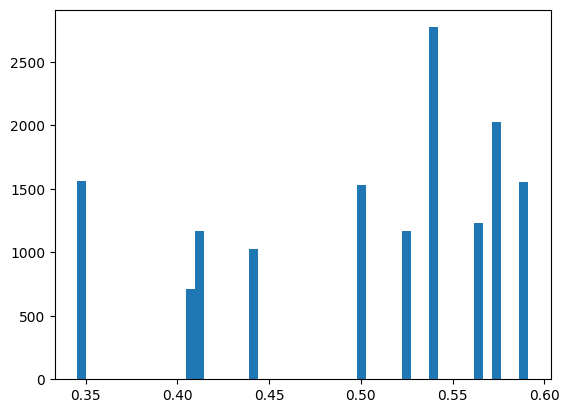

In [18]:
plt.hist(y_prob_test, bins = 50)

In [19]:
clf.best_config

{'n_estimators': 4,
 'num_leaves': 4,
 'min_child_samples': 32,
 'learning_rate': 0.09799718139270742,
 'log_max_bin': 10,
 'colsample_bytree': 0.8016216906969426,
 'reg_alpha': 0.0009765625,
 'reg_lambda': 1.696088560561417}

In [23]:
sorted(clf.feature_importances_)[::-1]

[7,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
